# German Credit Playground notebook

Structured as follows:

## 1. importing and data wrangling
## 2. logistic regression playground
## 3. neural network playground

First: 

## 1. importing and data wrangling

In [1]:
# import everything required
import numpy as np
import pandas as pd
import keras as ks
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.linear_model import LogisticRegression

# for reproducibility
np.random.seed(123)

/anaconda/envs/mlp/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load data
PATH="datasets/german_credit.csv"
raw_data = pd.read_csv(PATH, index_col=False)
df = pd.DataFrame(raw_data)
df

,ns1,ns2,ns3,ns4,ns5,ns6,ns7,ns8,s9,ns10,...,ns12,s13,ns14,ns15,ns16,ns17,ns18,ns19,ns20,y
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
5,A14,36,A32,A46,9055,A65,A73,2,A93,A101,...,A124,35,A143,A153,1,A172,2,A192,A201,1
6,A14,24,A32,A42,2835,A63,A75,3,A93,A101,...,A122,53,A143,A152,1,A173,1,A191,A201,1
7,A12,36,A32,A41,6948,A61,A73,2,A93,A101,...,A123,35,A143,A151,1,A174,1,A192,A201,1
8,A14,12,A32,A43,3059,A64,A74,2,A91,A101,...,A121,61,A143,A152,1,A172,1,A191,A201,1
9,A12,30,A34,A40,5234,A61,A71,4,A94,A101,...,A123,28,A143,A152,2,A174,1,A191,A201,2


In [3]:
# one-hot encode categorical variables
categoricals = ["ns1", "ns3", "ns4", "ns6", "ns7", "s9", "ns10", "ns12", "ns14", "ns15", "ns17", "ns19", "ns20"]
for a in categoricals:
    one_hot = pd.get_dummies(df[a])
    df = df.join(one_hot)
    df = df.drop(a, axis=1)
# create labels, drop labels from main database
y = df["y"]
df = df.drop("y", axis=1)

In [4]:
# normalise database
###MAYBE THIS NORMALISATION STEP IS BAD??????? COMMENTING OUT FOR NOW###
#df = (df - df.mean()) / df.var()
y = y - 1

In [5]:
# train-test split
X_train = df[0:800]
X_val = df[800:900]
X_test = df[900:1000]
y_train = y[0:800]
y_val = y[800:900]
y_test = y[900:1000]

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

## 2. logistic regression playground

I computed elsewhere that the feature with the biggest mutual information with the applicant's sex (`s9`) is feature `ns5`, i.e. the applicant's credit score. Annoyingly, this is also the feature that has highest mutual information with the target `y`. The goal of this section is to figure out whether this is bad news or not, by first computing the accuracy of a logistic regression with the credit score information untouched, and computing the accuracy of a logistic regression with the credit score information fiddled with.

### Untouched logistic regression:

In [21]:
def fit_logistic_regression(X, y):
    model = LogisticRegression()
    model = model.fit(X, y)
    
    return model
    #return model.coef_, model.intercept_, model.Score(X, y)

model = fit_logistic_regression(X_train, y_train)

print(model.score(X_val, y_val))
print(model.coef_)

0.75
[[ 2.79597913e-02  1.00601641e-04  3.28960262e-01 -5.10387188e-03
  -2.05891828e-02  2.51800826e-01  3.64444541e-01  5.44643166e-01
   2.73164630e-01 -3.31782533e-01 -1.12377276e+00  4.30940488e-01
   4.80031141e-01 -2.90669454e-01 -3.34618965e-01 -9.23430704e-01
   6.92806881e-01 -9.49922533e-01 -3.68535738e-01 -2.03922251e-01
  -1.70564854e-01 -4.73671222e-02  3.17565367e-01  6.27584139e-01
  -4.58872841e-01 -7.65185407e-02  3.63361676e-01  2.52421267e-02
  -1.21898199e-01 -5.95715709e-01 -3.08737389e-01  1.71444318e-01
   7.40667520e-02 -1.87366778e-02 -7.65999435e-01 -9.85224511e-02
   3.37895505e-01 -4.91948553e-02 -7.79415053e-01 -1.47033091e-01
  -1.83474001e-01  4.37746334e-01 -8.92019827e-01 -4.55995313e-01
  -6.41748150e-02 -2.83877393e-01  1.66300028e-01 -8.75234952e-02
  -3.34200516e-02 -5.16803947e-01  4.07503305e-02 -3.40621180e-01
  -3.37876644e-01 -3.81835014e-01 -2.00918479e-01 -1.51486471e-01
   9.64924707e-02 -1.58276723e-01 -4.79470771e-01  1.79749102e-01
  -8.

### Logistic regression with fiddled `ns5`

In [7]:
X_train_fiddled = X_train.copy()
X_train_fiddled['ns5'] += np.random.rand(1)*10000


model = fit_logistic_regression(X_train, y_train)

print(model.score(X_val, y_val))

0.75


This doesn't make sense to me, as I computed elsewhere (in my compute_mutual_information notebook) that the mutual information between the target and feature `ns5` is high, and so prediction accuracy should be affected if it is randomised. I do not know why this happened :(

## 3. neural networks playground

In [8]:
# from keras.models import Sequential
# from keras.layers import Dense

# create model
model = ks.Sequential()
model.add(ks.layers.Dense(200, activation='relu', input_shape=(61,)))
model.add(ks.layers.Dense(100, activation='relu'))
model.add(ks.layers.Dense(50, activation='relu'))
model.add(ks.layers.Dense(1, activation='sigmoid'))
# early stopping
es = ks.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=1, mode='auto')
# compile model
model.compile(loss='mean_squared_error', optimizer='adam')
# fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=1, 
          callbacks=[es], validation_split=0.5, validation_data=(X_val, y_val))

Train on 800 samples, validate on 100 samples
Epoch 1/100
800/800 [==============================] - 0s 584us/step - loss: 0.3188 - val_loss: 0.2900
Epoch 2/100
800/800 [==============================] - 0s 160us/step - loss: 0.2988 - val_loss: 0.2900
Epoch 3/100
800/800 [==============================] - 0s 137us/step - loss: 0.2987 - val_loss: 0.2900
Epoch 4/100
800/800 [==============================] - 0s 108us/step - loss: 0.2987 - val_loss: 0.2900
Epoch 5/100
800/800 [==============================] - 0s 90us/step - loss: 0.2987 - val_loss: 0.2900
Epoch 6/100
800/800 [==============================] - 0s 66us/step - loss: 0.2987 - val_loss: 0.2900
Epoch 00006: early stopping


800/800 [==============================] - 0s 75us/step
0.29 0.29875
dict_keys(['val_loss', 'loss'])


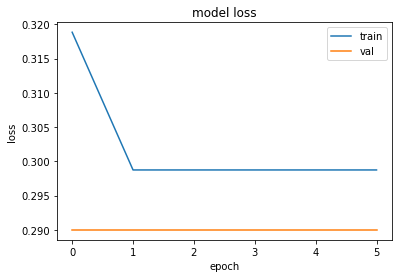

In [9]:
# evaluate the model
val_loss = model.evaluate(X_val, y_val)
train_loss = model.evaluate(X_train, y_train)
print(val_loss, train_loss)
# history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [10]:
print(model.predict(X_train[500:505]))
print(y_train[500:505])

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
500    1.0
501    0.0
502    0.0
503    1.0
504    1.0
Name: y, dtype: float32


## Random interlude: boostrapping!

In [11]:
base_scores = np.abs(model.predict(X_val) - y_val.values.reshape((100,1)))

In [12]:
def permute(x):
    n = len(x)
    score = 0
    for i in range(n):
        index = np.random.randint(n)
        score += x[index]
    return score

def bootstrap(x, number_of_times):
    histogram = np.zeros((number_of_times, 1))
    for i in range(number_of_times):
        histogram[i] = permute(x)
    return histogram

In [13]:
distribution = bootstrap(base_scores, 10000)

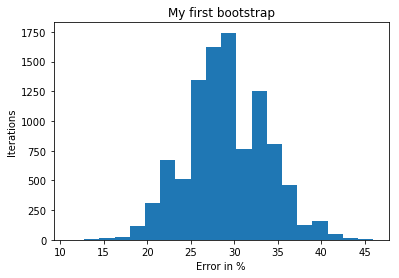

In [14]:
plt.hist(distribution, 20)
plt.title("My first bootstrap")
plt.ylabel("Iterations")
plt.xlabel("Error in %")
plt.show()

In [15]:
average = np.average(distribution)
var = np.var(distribution)
print("Average error is", average, "with variance", var)

Average error is 28.9828 with variance 21.11810416


I probably wanna plot a histogram of my funky data.

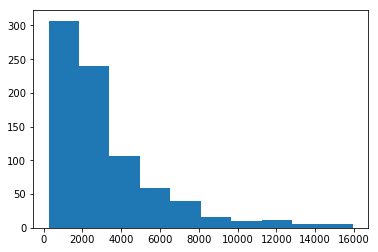

In [19]:
plt.hist(X_train['ns5'])
plt.show()

In [17]:
print(X_train.columns)

Index(['ns2', 'ns5', 'ns8', 'ns11', 's13', 'ns16', 'ns18', 'A11', 'A12', 'A13',
       'A14', 'A30', 'A31', 'A32', 'A33', 'A34', 'A40', 'A41', 'A410', 'A42',
       'A43', 'A44', 'A45', 'A46', 'A48', 'A49', 'A61', 'A62', 'A63', 'A64',
       'A65', 'A71', 'A72', 'A73', 'A74', 'A75', 'A91', 'A92', 'A93', 'A94',
       'A101', 'A102', 'A103', 'A121', 'A122', 'A123', 'A124', 'A141', 'A142',
       'A143', 'A151', 'A152', 'A153', 'A171', 'A172', 'A173', 'A174', 'A191',
       'A192', 'A201', 'A202'],
      dtype='object')


In [18]:
# To do 

look into GANs to augment data 
read a paper real quick



SyntaxError: invalid syntax (<ipython-input-18-45f6519c9f31>, line 3)